In [6]:
# Neccessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models,Input,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import zipfile
import pickle
import random
from google.colab import drive
import joblib
from sklearn.metrics import classification_report, confusion_matrix
drive.mount('/content/drive')
zip_ref=zipfile.ZipFile("/content/drive/MyDrive/Revitsone-5classes.zip","r")
zip_ref.extractall("/content/dataset")

In [32]:
# Functions required for loading the data, preprocessing the data, model creating and training, model evaluation, performance evaluation.

def load_data(data_path):
    other_images = []
    safe_images = []
    talk_images = []
    text_images = []
    turn_images = []
    invalid_other_images = [
        "img_79.jpg", "img_4664.jpg", "img_7973.jpg", "img_13318.jpg", "img_13396.jpg",
        "img_13541.jpg", "img_13625.jpg", "img_20398.jpg", "img_22266.jpg"
    ]

    invalid_turn_images = [
        "img_8771.jpg", "img_62337.jpg", "img_67523.jpg", "img_70552.jpg", "img_84605.jpg",
        "img_101434.jpg"
    ]

    for root, dirs, files in os.walk(data_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                category = image_path.split("/")[-2]
                image_name = image_path.split("/")[-1]
                if category == "other_activities":
                    if image_name in invalid_other_images:
                        pass
                    else:
                        other_images.append(image_path)
                elif category == "safe_driving":
                    safe_images.append(image_path)
                elif category == "texting_phone":
                    text_images.append(image_path)
                elif category == "talking_phone":
                    talk_images.append(image_path)
                elif category == "turning":
                    if image_name in invalid_turn_images:
                        pass
                    else:
                        turn_images.append(image_path)
            except:
                pass

    other_images = np.array(other_images)
    safe_images = np.array(safe_images)
    talk_images = np.array(talk_images)
    text_images = np.array(text_images)
    turn_images = np.array(turn_images)

    return other_images, safe_images, talk_images, text_images, turn_images

def split_data(data):
    l = data.shape[0]
    return data[:int(l * 0.8)], data[int(l * 0.8):int(l * 0.8) + int(l * 0.1)], data[int(l * 0.8) + int(
        l * 0.1):int(l * 0.8) + int(l * 0.1) + int(l * 0.1)]

def prepare_data_for_model(other_images, safe_images, talk_images, text_images, turn_images):
    other_train, other_valid, other_test = split_data(other_images)
    safe_train, safe_valid, safe_test = split_data(safe_images)
    talk_train, talk_valid, talk_test = split_data(talk_images)
    text_train, text_valid, text_test = split_data(text_images)
    turn_train, turn_valid, turn_test = split_data(turn_images)

    train_data = np.concatenate((other_train, safe_train, talk_train, text_train, turn_train))
    train_labels = np.concatenate((["other" for _ in range(len(other_train))],
                                   ["safe" for _ in range(len(safe_train))],
                                   ["talk" for _ in range(len(talk_train))],
                                   ["text" for _ in range(len(text_train))],
                                   ["turn" for _ in range(len(turn_train))]))
    valid_data = np.concatenate((other_valid,safe_valid,talk_valid,text_valid,turn_valid))
    valid_labels = np.concatenate((["other" for i in range(len(other_valid))],
                                   ["safe" for i in range(len(safe_valid))],
                                   ["talk" for i in range(len(talk_valid))],
                                   ["text" for i in range(len(text_valid))],
                                   ["turn" for i in range(len(turn_valid))]))
    test_data = np.concatenate((other_test,safe_test,talk_test,text_test,turn_test))
    test_labels = np.concatenate((["other" for i in range(len(other_test))],
                                  ["safe" for i in range(len(safe_test))],
                                  ["talk" for i in range(len(talk_test))],
                                  ["text" for i in range(len(text_test))],
                                  ["turn" for i in range(len(turn_test))]))

    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels

def create_data_generators(train_data, train_labels, valid_data, valid_labels, test_data, test_labels, batch_size):
    train_df = pd.DataFrame({"images": train_data, "labels": train_labels})
    test_df = pd.DataFrame({"images": test_data, "labels": test_labels})
    valid_df = pd.DataFrame({"images": valid_data, "labels": valid_labels})

    image_width = 240
    image_height = 240

    trainGenerator = ImageDataGenerator(
        rescale=1. / 255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    valGenerator = ImageDataGenerator(rescale=1. / 255.)
    testGenerator = ImageDataGenerator(rescale=1. / 255.)

    trainDataset = trainGenerator.flow_from_dataframe(
        dataframe=train_df,
        class_mode="categorical",
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        target_size=(image_height, image_width)
    )

    testDataset = testGenerator.flow_from_dataframe(
        dataframe=test_df,
        class_mode='categorical',
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        target_size=(image_height, image_width)
    )

    valDataset = valGenerator.flow_from_dataframe(
        dataframe=valid_df,
        class_mode='categorical',
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        target_size=(image_height, image_width)
    )

    return trainDataset, valDataset, testDataset

def VGGNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(64, 3, 1, activation='relu')(inp)
    x = layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_VGG = models.Model(inputs=inp, outputs=x)

    return model_VGG

def train_model(model, train_dataset, val_dataset, epochs):
    model.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    return model, history

def evaluate_model(model, test_dataset):
    model.evaluate(test_dataset)

def model_training_visualization(history):
  plt.plot(history.history["accuracy"])
  plt.title("Training accuracy VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(history.history["loss"])
  plt.title("Training loss VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(history.history["val_accuracy"])
  plt.title("Validation accuracy VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(history.history["val_loss"])
  plt.title("Validation loss VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

def evaluate_model_metrics(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print()
    test_dataset.reset()
    predictions = model.predict(test_dataset, verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    true_labels = (test_dataset.class_indices)
    true_labels = dict((v, k) for k, v in true_labels.items())
    true_labels = [true_labels[k] for k in predicted_class_indices]

    print("\nClassification Report:")
    print(classification_report(test_dataset.classes, predicted_class_indices, target_names=test_dataset.class_indices))
    print()
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_dataset.classes, predicted_class_indices))

def plot_images(images, labels_true, labels_pred, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {labels_true[i]} || Predicted: {labels_pred[i]}")
        plt.axis('off')
    plt.show()

In [3]:
# Loading the data
data_path = r"/content/dataset/Revitsone-5classes"
other_images, safe_images, talk_images, text_images, turn_images = load_data(data_path)

# Over-sampling the "safe" category data as more data points is needed for a better performance on the real time prediction analysis
safe_images=list(safe_images)
for i in range(len(safe_images)):
  safe_images.append(safe_images[np.random.randint(0,len(safe_images))])
safe_images=np.array(safe_images)

# Preparing the data for model
train_data, train_labels, valid_data, valid_labels, test_data, test_labels = prepare_data_for_model(
other_images, safe_images, talk_images, text_images, turn_images)

# Creating the data generators
batch_size = 64
train_dataset, val_dataset, test_dataset = create_data_generators(train_data, train_labels, valid_data, valid_labels, test_data, test_labels, batch_size)

Found 10361 validated image filenames belonging to 5 classes.
Found 1292 validated image filenames belonging to 5 classes.
Found 1292 validated image filenames belonging to 5 classes.


In [4]:
# Creating the VGG model
model_VGG = VGGNet()

# Training the model
epochs = 30
model_VGG, history = train_model(model_VGG, train_dataset, val_dataset, epochs)

Epoch 1/30
162/162 [==============================] - 204s 1s/step - loss: 5.3185 - accuracy: 0.2895 - val_loss: 0.4988 - val_accuracy: 0.3406
Epoch 2/30
162/162 [==============================] - 154s 948ms/step - loss: 0.4827 - accuracy: 0.3563 - val_loss: 0.4866 - val_accuracy: 0.3684
Epoch 3/30
162/162 [==============================] - 154s 951ms/step - loss: 0.5387 - accuracy: 0.3876 - val_loss: 0.4834 - val_accuracy: 0.3506
Epoch 4/30
162/162 [==============================] - 153s 944ms/step - loss: 0.5814 - accuracy: 0.3595 - val_loss: 0.4349 - val_accuracy: 0.4474
Epoch 5/30
162/162 [==============================] - 153s 945ms/step - loss: 0.4347 - accuracy: 0.4778 - val_loss: 0.3894 - val_accuracy: 0.5201
Epoch 6/30
162/162 [==============================] - 153s 942ms/step - loss: 0.3155 - accuracy: 0.6203 - val_loss: 0.2605 - val_accuracy: 0.7005
Epoch 7/30
162/162 [==============================] - 153s 946ms/step - loss: 0.2195 - accuracy: 0.7538 - val_loss: 0.1447 - va

In [18]:
# Saving the model weights and training progress

joblib.dump(model_VGG, "/content/drive/MyDrive/modelvgg.pkl")
joblib.dump(history, "/content/drive/MyDrive/history.pkl")

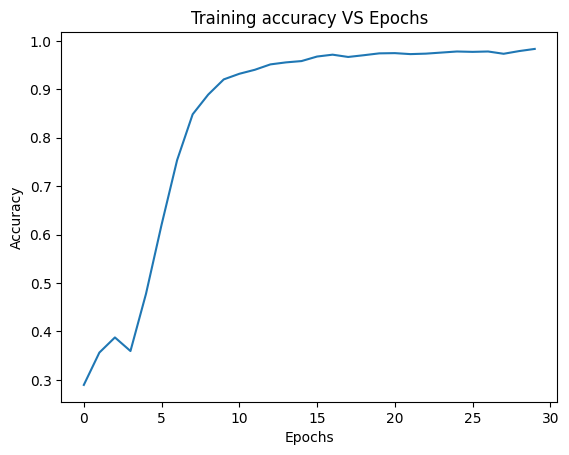

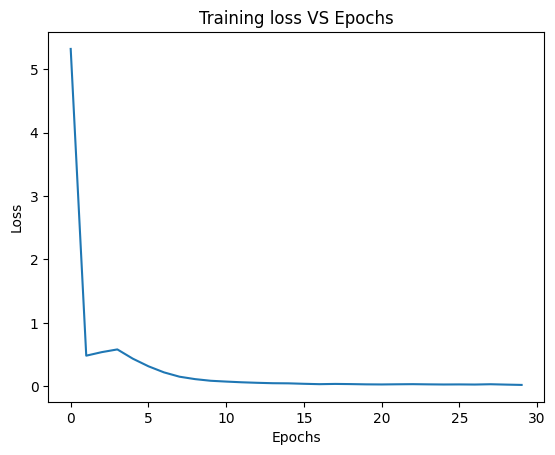

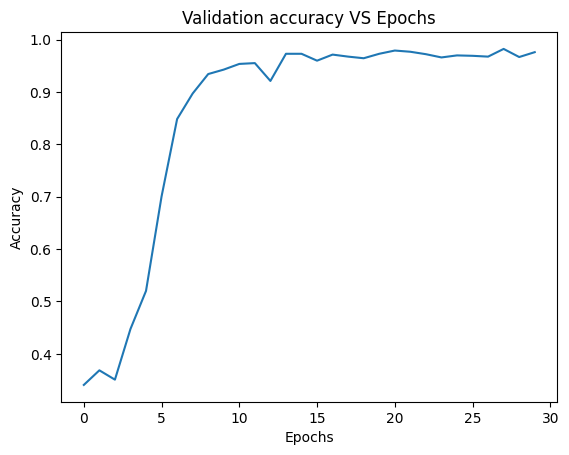

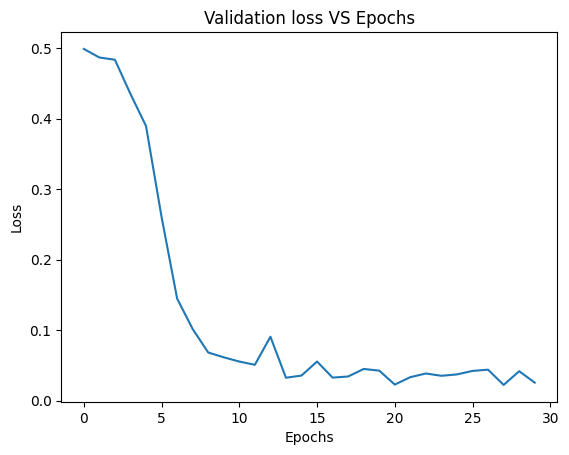

In [20]:
# Visualizing the model training progress

model_training_visualization(history)

In [22]:
# Evaluating the performance of the trained model on the test (unseen) data.

evaluate_model_metrics(model_VGG, test_dataset)

21/21 [==============================] - 6s 251ms/step - loss: 0.0266 - accuracy: 0.9799
Test Loss: 0.0266
Test Accuracy: 97.99%

21/21 [==============================] - 6s 263ms/step

Classification Report:
              precision    recall  f1-score   support

       other       0.98      0.94      0.96       211
        safe       0.98      1.00      0.99       440
        talk       0.98      0.98      0.98       216
        text       0.98      0.98      0.98       220
        turn       0.99      0.98      0.98       205

    accuracy                           0.98      1292
   macro avg       0.98      0.98      0.98      1292
weighted avg       0.98      0.98      0.98      1292



Confusion Matrix:
[[198   6   5   0   2]
 [  0 440   0   0   0]
 [  1   1 212   2   0]
 [  2   1   0 216   1]
 [  2   1   0   2 200]]


21/21 [==============================] - 5s 261ms/step


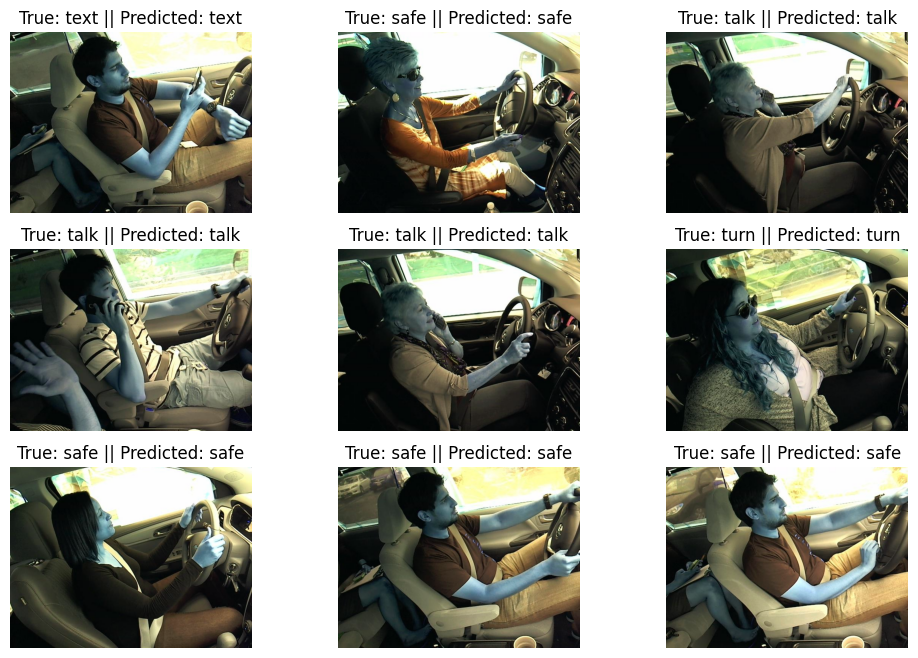

In [33]:
# Plotting few test images for testing our trained models performance

test_dataset.reset()
pred = model_VGG.predict(test_dataset, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_labels = test_dataset.classes
true_class_indices = test_dataset.labels
class_names = list(test_dataset.class_indices.keys())
random_indices = np.random.choice(len(test_dataset.filenames), size=9, replace=False)
random_images = [cv2.imread(test_dataset.filepaths[i]) for i in random_indices]
random_labels_true = [class_names[true_labels[i]] for i in random_indices]
random_labels_pred = [class_names[predicted_class_indices[i]] for i in random_indices]

plot_images(random_images, random_labels_true, random_labels_pred, class_names)